In [1]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

from ClusterPipeline import ClusterPipeline
from helper import plot_confusion_matrix

import numpy as np
import pandas as pd

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
import numpy as np

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [3]:
def get_split_index(features, labels, test_size=0.1):
    import numpy as np
    from sklearn.model_selection import StratifiedShuffleSplit
    
    features = np.array(features)
    # The train set will have equal amounts of each target class
    # Performing single split
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    return [[train_index, test_index] for train_index,test_index in split.split(features, labels)]

def split_valid(features, training_labels, valid_size=0.5):
    train_index, validation_index = get_split_index(features, training_labels, test_size=valid_size)[0]
    
    X_valid, y_valid = features.iloc[validation_index], training_labels.iloc[validation_index]
    X_train, y_train = features.iloc[train_index], training_labels.iloc[train_index]
     
    return X_train, y_train, X_valid, y_valid

In [4]:
raw_data = pd.read_csv("data/heart.csv")
original_data = raw_data.drop(columns=["target"])
training_labels = raw_data["target"]
raw_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
def exp_decay(epoch):
    initial_lr = 0.1
    decay_steps = 50
    decay_rate = 0.1
    
    decayed_lr =  initial_lr * np.power(decay_rate, (epoch/decay_steps))
#     print("New Learning Rate:", decayed_lr)
    return decayed_lr

def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    

    dnn.add(Dense(units = 50, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units = 25, activation="elu",
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units=10, activation='elu',
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

In [6]:
## Need to define a scaling function that ignores categorical values...?

In [7]:
nn = build_dnn(num_features=original_data.shape[1])
nn.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                700       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                260       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 22        
Total para

In [8]:
# Separating a hold out set that will be used for validation later
X_train, y_train, X_valid, y_valid = split_valid(original_data, training_labels, valid_size=0.3)    

pipeline = ClusterPipeline(nn, [X_train, y_train], [X_valid,y_valid], target_class=1)

pipeline.train_model(batch_size=20,epochs=100, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Instructions for updating:
Use tf.cast instead.
Fold: 0 -> Loss:0.604, Acc:0.8544
Prediction Accuracy
22/22 [==============================] - 0s 2ms/step
Scores on data set: loss=0.479 accuracy=0.8636
Fold Correct: 19
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Running worker: 1
Fold: 1 -> Loss:0.633, Acc:0.8689
Prediction Accuracy
22/22 [==============================] - 0s 19us/step
Scores on data set: loss=0.623 accuracy=0.8182
Fold Correct: 18
Running worker: 2
Fold: 2 -> Loss:0.602, Acc:0.8641
Prediction Accuracy
22/22 [==============================] - 0s 23us/step
Scores on data set: loss=0.720 accuracy=0.8636
Fold Correct: 19
Running worker: 3
Fold: 3 -> Loss:0.615, Acc:0.8738
Prediction Accuracy
22/22 [==============================] - 0s 30us/step
Scores on data set: loss=0.614 accuracy=0.8636
Fold Correct: 19
Running worker: 4
Fold: 4 -> Loss:0.577, Acc:0.8689
Prediction Accuracy
22/22 [=====

Confusion matrix, without normalization
[[ 78  19]
 [ 15 100]]


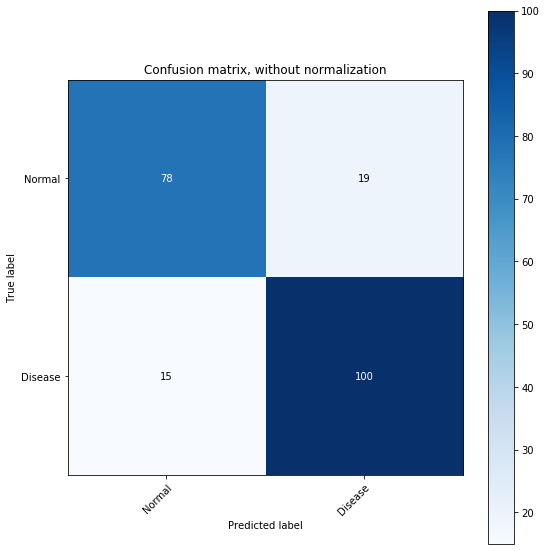

In [9]:
plot_confusion_matrix(y_train.values[pipeline.testing_idxs], np.array(pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

Normalized confusion matrix
[[0.80412371 0.19587629]
 [0.13043478 0.86956522]]


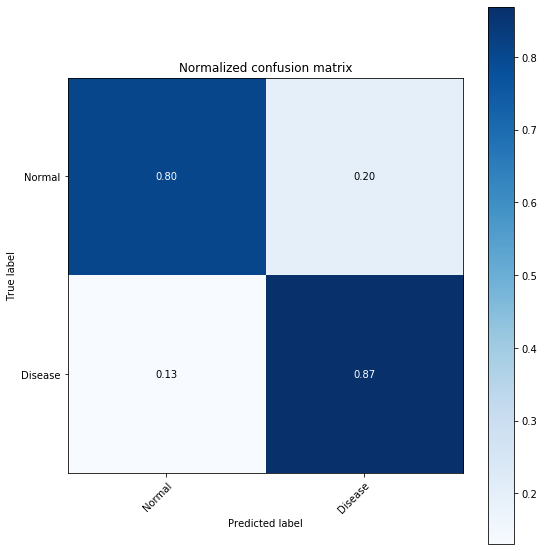

In [97]:
plot_confusion_matrix(y_train.values[pipeline.testing_idxs], np.array(pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]), normalize=True)

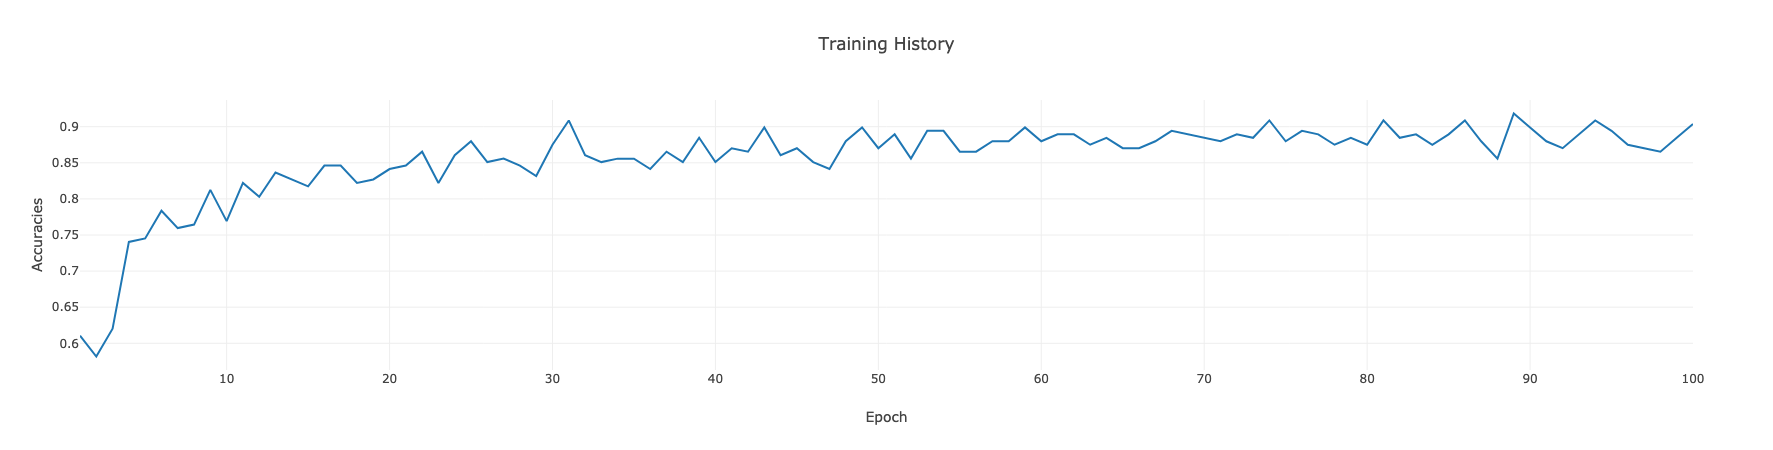

In [10]:
from plotly.offline import iplot
from plotly.offline import plot

accs = nn.history.history["acc"]
loss = nn.history.history["loss"]

accs_plot = go.Scatter(
    x=[x for x in range(1,len(accs)+1)],
    y=accs,
    mode="lines",
    name="line plot"
)

data = [accs_plot]

layout = go.Layout(
    title= "Training History",
    yaxis= {"title":"Accuracies"},
    xaxis={"title":"Epoch"}
)

fig = go.Figure(data=data, layout=layout)


iplot(fig)

In [11]:
min_cluster_sizes=range(3,20,1)
pipeline.train_clusterer(min_cluster_sizes=min_cluster_sizes, plot=False)

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py:349: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/numba/compiler.py:725: NumbaWarning:

Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/numba/compiler.py:734

Minimum Size:
Clusters                  4
Noise                     3
Silhouette                5
Halkidi                   3
Halkidi-Filtered Noise    5
Halkidi-Bounded Noise     3
dtype: int64


,Clusters,Noise,Silhouette,Halkidi,Halkidi-Filtered Noise,Halkidi-Bounded Noise
3,2,0.70,-4.832944e-02,1.722439e+00,1.663334e+00,1.838133e+00
4,0,1.00,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
5,2,0.77,-1.081600e-01,1.746451e+00,1.589243e+00,1.871966e+00
6,0,1.00,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
7,0,1.00,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
8,0,1.00,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
9,0,1.00,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
10,0,1.00,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
11,0,1.00,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
12,0,1.00,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09


In [12]:
pd.Series(pipeline.clusterer.labels_).value_counts()

-1    77
 1    17
 0     6
dtype: int64

In [13]:
# Internally populates self.val_set_lrp
samples, cluster_labels = pipeline.get_validation_clusters()

Loading LRP Analyzers...
Done!


In [14]:
pd.Series(cluster_labels).value_counts()

-1    45
dtype: int64

In [15]:
# pipeline.val_set_lrp

## Plotting Testing LRP

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

correct_pred_labels = pipeline.train_set.labels.iloc[pipeline.testing_idxs][pipeline.correct_preds_bool_arr]
split_class = correct_pred_labels == pipeline.target_class
split_class_lrp = np.array(pipeline.lrp_results)[split_class]

lrp_data = np.clip(split_class_lrp, 0,None)
val_lrp = np.clip(pipeline.val_set_lrp, 0,None)

# s_lrp_data = MinMaxScaler().fit_transform(lrp_data)

In [17]:
labels = correct_pred_labels[split_class]
len(labels)

100

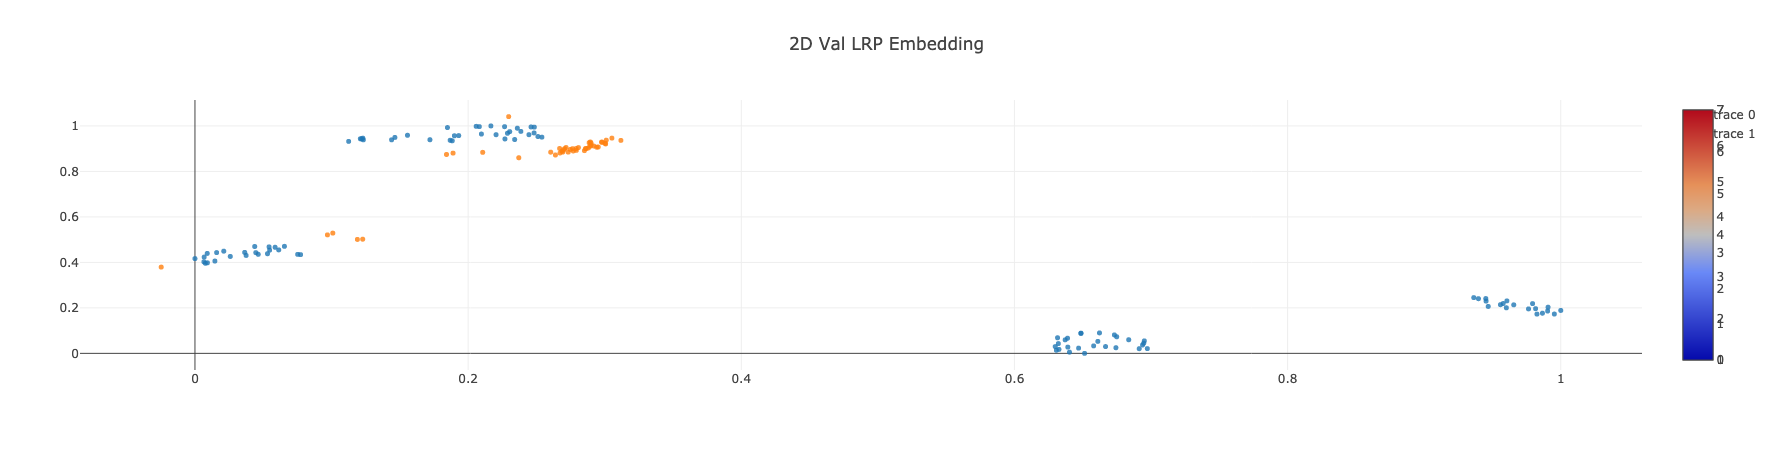

In [18]:
import umap
from matplotlib import pyplot as plt

embedding_pipeline_2d = Pipeline([
    ("reducer", umap.UMAP(random_state=42,
                    n_components = 2,
                    n_neighbors=10,
                    min_dist=0)),
   ("scaler", MinMaxScaler())
])
embedding_pipeline_2d.fit(lrp_data)
embedding = embedding_pipeline_2d.transform(lrp_data)
val_embedding = embedding_pipeline_2d.transform(val_lrp)

emb2d = go.Scatter(
    x=embedding[:,0],
    y=embedding[:,1],
    mode="markers",
    marker=dict(
        size=5,
        colorscale='Rainbow',
        opacity=0.8,
        showscale=True
    )
)

val_emb2d = go.Scatter(
    x=val_embedding[:,0],
    y=val_embedding[:,1],
    mode="markers",
    marker=dict(
        size=5,
        colorscale='RdBu',
        opacity=0.8,
        showscale=True
    )
)

layout2d = go.Layout(
    title= "2D Val LRP Embedding"
)

data=[emb2d, val_emb2d]

fig = go.Figure(data=data, layout=layout2d)
iplot(fig)

## Using UMAP as a preprocessing step to either
   ### - Reduce dimenions to improvce HDBSCAN performance
   ### - Contract clusters on a manifold inside the original dimension

In [19]:
embedding_pipeline = Pipeline([
    ("reducer", umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=15,
                    min_dist=0)),
   ("scaler", MinMaxScaler())
])
embedding_pipeline.fit(lrp_data)

Pipeline(memory=None,
         steps=[('reducer',
                 UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
                      learning_rate=1.0, local_connectivity=1.0,
                      metric='euclidean', metric_kwds=None, min_dist=0,
                      n_components=10, n_epochs=None, n_neighbors=15,
                      negative_sample_rate=5, random_state=42,
                      repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
                      target_metric='categorical', target_metric_kwds=None,
                      target_n_neighbors=-1, target_weight=0.5,
                      transform_queue_size=4.0, transform_seed=42,
                      verbose=False)),
                ('scaler', MinMaxScaler(copy=True, feature_range=(0, 1)))],
         verbose=False)

In [20]:
import hdbscan
lrp_embedding = embedding_pipeline.transform(lrp_data)

clusterer = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=15,prediction_data=True)
clusterer.fit(lrp_embedding)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_method='eom',
        core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=15, min_samples=15, p=None,
        prediction_data=True)

In [21]:
pd.Series(clusterer.labels_).value_counts()

1    32
3    26
0    23
2    19
dtype: int64

In [22]:
embedding_pipeline_3d = Pipeline([
    ("reducer", umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=7,
                    min_dist=0)),
   ("scaler", MinMaxScaler())
])
embedding_pipeline_3d.fit(lrp_data)

embedding = embedding_pipeline_3d.transform(lrp_data)

emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    marker=dict(
        size=5,
        color=clusterer.labels_,
        colorscale="Rainbow",
        opacity=0.8
    ),
    text=clusterer.labels_
)

layout = go.Layout(
    title= "Val LRP Embedding",
     margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=[emb3d], layout=layout)
iplot(fig, filename='lrp-val.html')

### Validation LRP after UMAP Embedding

In [23]:
val_embedding = embedding_pipeline.transform(val_lrp)


cluster_labels, strengths = hdbscan.approximate_predict(clusterer, val_embedding)
pd.Series(cluster_labels).value_counts()

1    41
0     4
dtype: int64

In [24]:
val_3d_embedding = embedding_pipeline_3d.transform(val_lrp)

val_emb3d = go.Scatter3d(
    x=val_3d_embedding[:,0],
    y=val_3d_embedding[:,1],
    z=val_3d_embedding[:,2],
    mode="markers",
    marker=dict(
        size=5,
        color=cluster_labels,
        colorscale='Viridis',
        opacity=0.8,
        showscale=True
    ),
    text = cluster_labels
)

layout = go.Layout(
    title= "Val LRP Embedding",
     margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

data=[val_emb3d]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='lrp-val.html')

## Plotting high dimensional clusters in lower dims

> Note that data points that cluster in higher dims do not *have* to cluster in lower dim UMAP projections

**Use the lower dims only for plotting and visual verification / data exploration**

In [25]:
data=[emb3d, val_emb3d]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='lrp-val.html')

## Hyper Parameter search for HDBSCAN

In [26]:
from s_dbw import S_Dbw

ii32 = np.iinfo(np.int32)

plot=False        # FIXME: Assumes 2D data only
if plot:
    plt.close("Cluster Comparison") #1+len(cluster_sizes)
    fig, axs = plt.subplots(1+len(cluster_sizes), 1, figsize=(15,6*(+len(cluster_sizes))), num="Cluster Comparison")
    plt.title("Cluster Comparison")

    axs[0].scatter(*data.T, s=50, linewidth=0, c=labels, alpha=0.5, cmap="Set1")
    axs[0].set_title("Original Distribution")

_metrics = []
cluster_sizes = range(10,17)
data = lrp_embedding
min_samp_start = 10

for i,size in enumerate(cluster_sizes):
    min_samples = range(min_samp_start,size+1)

    for j,min_s in enumerate(min_samples):
        clusterer = hdbscan.HDBSCAN(min_cluster_size=size, min_samples=min_s)
        clusterer.fit(data)
        cluster_labels = clusterer.labels_

        ## Number of clusters in labels, ignoring noise if present.
        num_clusters = cluster_labels.max() + 1

    #     color_palette = sns.color_palette("bright", num_clusters)
    #     cluster_colors = [color_palette[x] if x >= 0
    #                     else (0, 0, 0)
    #                     for x in clusterer.labels_]
    #     cluster_member_colors = [sns.desaturate(x, p) for x, p in
    #                             zip(cluster_colors, clusterer.probabilities_)]

        # print(cluster_labels)
        noise, halkidi_s_Dbw, halkidi_ignore_noise, halkidi_bind = [ii32.max]*4

        noise = list(cluster_labels).count(-1)/len(cluster_labels)
#         print(size,min_s)
#         print(pd.Series(clusterer.labels_).value_counts())
        if num_clusters > 1:
            halkidi_s_Dbw = S_Dbw(data, cluster_labels, alg_noise="comb", method='Halkidi',
                        centr='mean', nearest_centr=True, metric='euclidean')

            halkidi_ignore_noise = S_Dbw(data, cluster_labels, alg_noise="filter", method='Halkidi',
                        centr='mean', nearest_centr=True, metric='euclidean')

            halkidi_bind = S_Dbw(data, cluster_labels, alg_noise="bind", method='Halkidi',
                        centr='mean', nearest_centr=True, metric='euclidean')


        _metrics.append([num_clusters,noise, halkidi_s_Dbw, halkidi_ignore_noise, halkidi_bind])

        if plot:
            axs[i+1].scatter(*data.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.6)
            axs[i+1].set_title("Minimum Cluster Size: {}".format(size))
            axs[i+1].text(0.95,0.95,"Clusters Found: {}".format(num_clusters),
                    horizontalalignment='right', verticalalignment='top',
                    fontsize=14, transform=axs[i+1].transAxes)

    if plot:
        plt.tight_layout()
        plt.show()
        plt.savefig(self.FIGUREDIR+"cluster_perf_comp.png")
        plt.close("Cluster Comparison")

In [27]:
index  = [y for x in cluster_sizes for y in list(zip([x]*x,range(min_samp_start,x+1))) ]
scores = pd.DataFrame(_metrics, columns=["Clusters", "Noise","Halkidi", "Halkidi-Filtered Noise", "Halkidi-Bounded Noise"], index=index)
scores

,Clusters,Noise,Halkidi,Halkidi-Filtered Noise,Halkidi-Bounded Noise
"(10, 10)",4,0.0,0.088481,0.088481,0.088481
"(11, 10)",4,0.0,0.088481,0.088481,0.088481
"(11, 11)",4,0.0,0.088481,0.088481,0.088481
"(12, 10)",4,0.0,0.088481,0.088481,0.088481
"(12, 11)",4,0.0,0.088481,0.088481,0.088481
"(12, 12)",4,0.0,0.088481,0.088481,0.088481
"(13, 10)",4,0.0,0.088481,0.088481,0.088481
"(13, 11)",4,0.0,0.088481,0.088481,0.088481
"(13, 12)",4,0.0,0.088481,0.088481,0.088481
"(13, 13)",4,0.0,0.088481,0.088481,0.088481


In [28]:
scores.idxmin()

Clusters                  (10, 10)
Noise                     (10, 10)
Halkidi                   (10, 10)
Halkidi-Filtered Noise    (10, 10)
Halkidi-Bounded Noise     (10, 10)
dtype: object

In [29]:
msize, msamp = scores["Halkidi-Filtered Noise"].idxmin()

clusterer = hdbscan.HDBSCAN(min_cluster_size=msize, min_samples=msamp, prediction_data=True)
clusterer.fit(lrp_embedding)
pd.Series(clusterer.labels_).value_counts()

1    32
3    26
0    23
2    19
dtype: int64

In [30]:
emb3d["marker"]["color"]=clusterer.labels_
emb3d["text"]=clusterer.labels_

fig = go.Figure(data=[emb3d], layout=layout)
iplot(fig, filename='lrp-val.html')

In [31]:
cluster_labels, strengths = hdbscan.approximate_predict(clusterer, val_embedding)
pd.Series(cluster_labels).value_counts()

1    41
0     4
dtype: int64

In [32]:
val_emb3d["marker"]["color"]=cluster_labels
val_emb3d["text"]=cluster_labels

data=[val_emb3d]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='lrp-val.html')

In [33]:
data=[emb3d, val_emb3d]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='lrp-val.html')

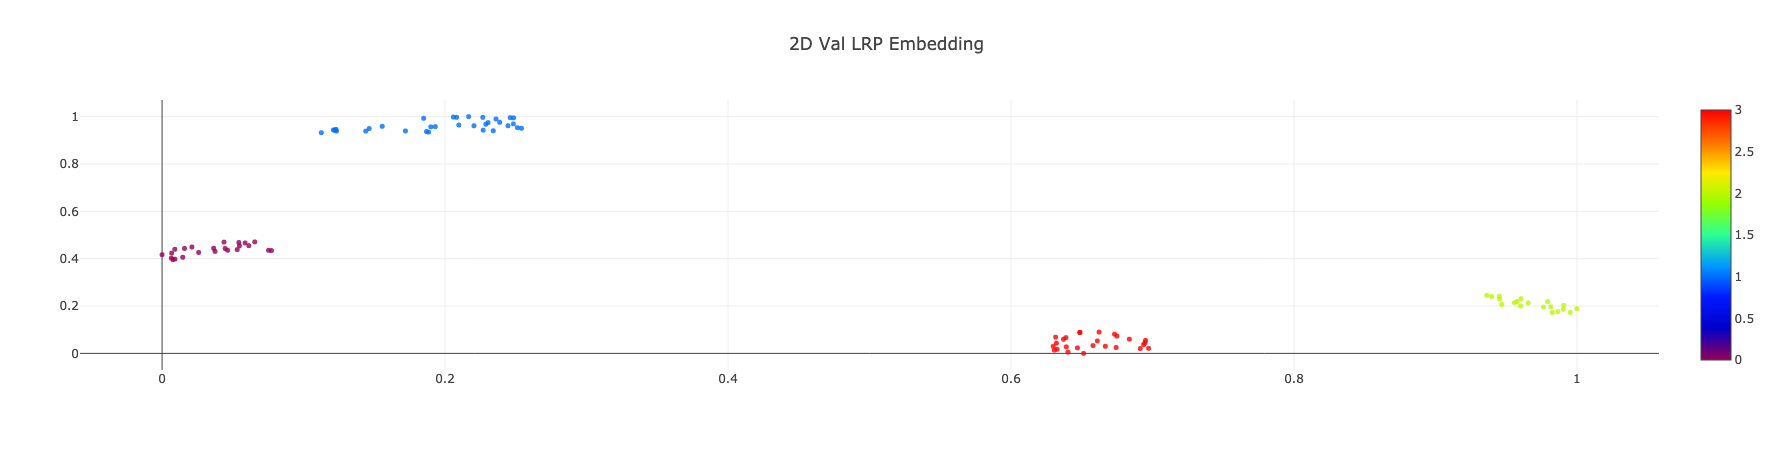

In [34]:
emb2d["marker"]["color"]=clusterer.labels_
emb2d["text"]=clusterer.labels_

data=[emb2d]

fig = go.Figure(data=data, layout=layout2d)
iplot(fig)

## Plotting Validation LRP

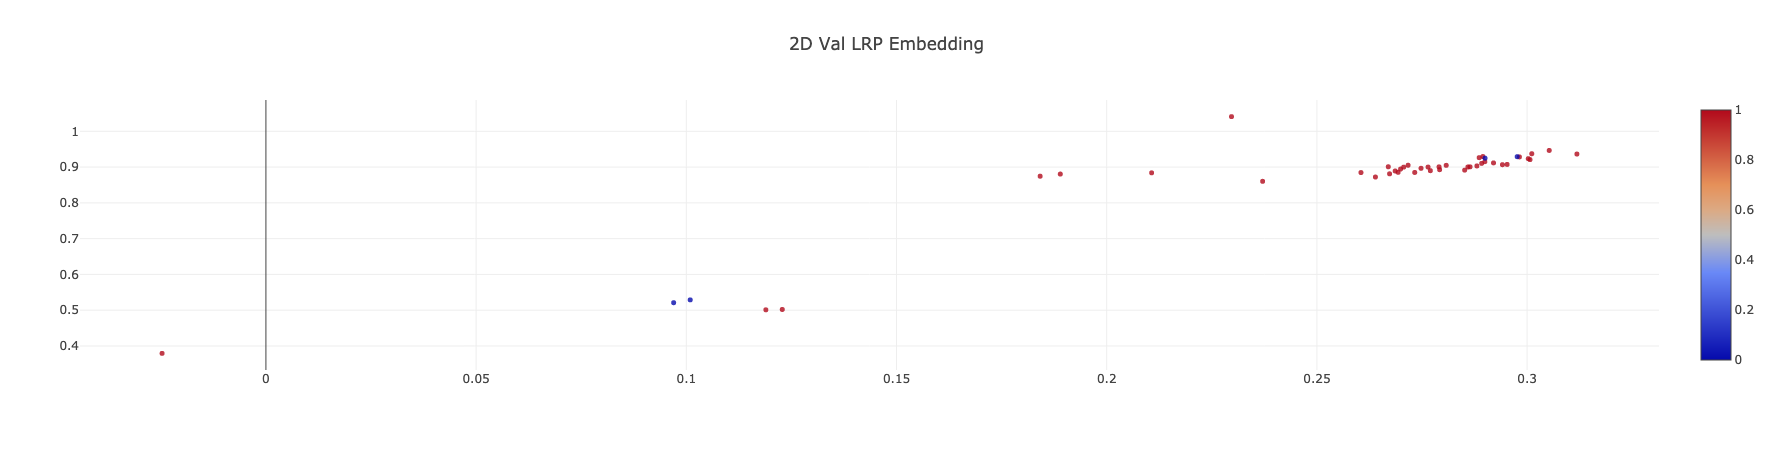

In [35]:
val_emb2d["marker"]["color"]=cluster_labels
val_emb2d["text"]=cluster_labels

data=[val_emb2d]

fig = go.Figure(data=data, layout=layout2d)
iplot(fig, filename='lrp-val.html')

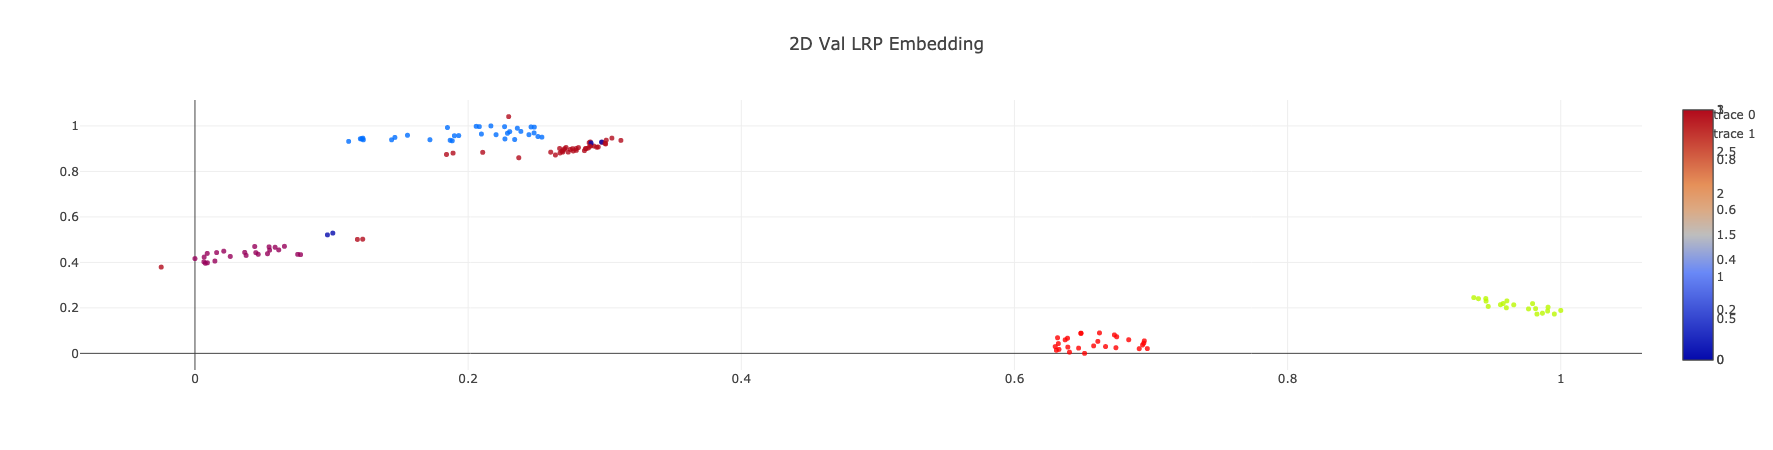

In [36]:
data=[emb2d, val_emb2d]

fig = go.Figure(data=data, layout=layout2d)
iplot(fig, filename='lrp-val.html')

# Performing Feature Reduction

In [37]:
def get_relevant_cols(df, thresh = 1e-2):

    all_above_thresh = (df < thresh).all(0) #Check if all values in columns satisfy the criteria
    max_above_thresh = (df.max() < thresh)
    quantile_above_thresh = (df.quantile(0.8) <= thresh)

    criteria = quantile_above_thresh
    irrelevant_cols = df.columns[criteria] 
    irrelevant_cols
    
    relevant_features_only = df.drop(columns = irrelevant_cols)
    
    return relevant_features_only

In [38]:
largest_cluster = pd.Series(cluster_labels).value_counts().idxmax()
largest_cluster

1

In [39]:
cluster_label = largest_cluster
val_clustered = pd.DataFrame(val_lrp[(cluster_labels == cluster_label)], columns = X_train.columns)

In [40]:
val_clustered.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,41.0,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,0.0,0.015598,0.004048,0.059011,12.726345,0.003910,0.014192,0.327928,0.006131,0.036058,0.004567,0.012530,0.284625
std,0.0,0.016732,0.025918,0.368459,5.824697,0.008107,0.017317,2.099765,0.025713,0.050281,0.010016,0.043182,0.131351
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000,10.667024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.253237
50%,0.0,0.000000,0.000000,0.000000,12.762233,0.000000,0.004887,0.000000,0.000000,0.011328,0.001671,0.000000,0.278167
75%,0.0,0.034446,0.000000,0.000000,15.061973,0.000000,0.029286,0.000000,0.000000,0.061599,0.004257,0.000000,0.318447
max,0.0,0.036493,0.165959,2.360029,34.944454,0.024147,0.065464,13.445047,0.139261,0.247249,0.060373,0.200937,0.732782


In [41]:
# thresh = min(val_clustered.describe().loc["75%"])

In [57]:
reduced_val = get_relevant_cols(val_clustered, thresh=0)
reduced_val.head()

,sex,chol,restecg,oldpeak,slope,thal
0,0.000000,14.483445,0.000000,0.000000,0.004141,0.282495
1,0.034623,12.762233,0.000000,0.121091,0.003402,0.266833
2,0.000000,13.222886,0.000000,0.077870,0.003393,0.361274
3,0.034917,18.567335,0.000000,0.025277,0.000000,0.338785
4,0.034996,10.807798,0.029286,0.005195,0.004873,0.272932


## Using reduced features for retraining

> **Only values from the same cluster can be retrained**

In [43]:
feature_idxs = reduced_val.columns
feature_idxs

Index(['sex', 'chol', 'restecg', 'oldpeak', 'slope', 'thal'], dtype='object')

In [44]:
# ~target_samples

In [123]:
# Ideally only get samples belonging to subclusters

# Separating Control from Target
reindexer = pipeline.testing_idxs
correct_preds = pipeline.correct_preds_bool_arr

target_samples = y_train.iloc[reindexer][correct_preds] == pipeline.target_class
control_samples = ~target_samples

tsamples = X_train.iloc[reindexer][correct_preds][target_samples]
tlabels = y_train.iloc[reindexer][correct_preds][target_samples]

tsamples = tsamples[(clusterer.labels_ == cluster_label)]
tlabels = tlabels[(clusterer.labels_ == cluster_label)]


csamples = X_train.iloc[reindexer][correct_preds][control_samples]
csamples = csamples[:len(tsamples)]

clabels = y_train.iloc[reindexer][correct_preds][control_samples]
clabels = clabels[:len(tsamples)]


#Now stack it with control values of same size.. 
X_train_sc = pd.concat([csamples, tsamples], axis="index")
y_train_sc = pd.concat([clabels, tlabels], axis="index")

In [124]:
# All the samples from X_valid are used for now...
X_valid_red = X_valid[feature_idxs]

nn = build_dnn(num_features=X_train_sc.shape[1])
# nn.summary()

### Baseline CN vs Subcluster

> **Reusing the same network architecture may not be valid as the samples are already biased towards it**

In [125]:
baseline_pipeline = ClusterPipeline(nn, [X_train_sc, y_train_sc], [X_valid, y_valid], target_class=1)

baseline_pipeline.train_model(batch_size=20,epochs=100, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.424, Acc:1.0000
Prediction Accuracy
8/8 [==============================] - 0s 6ms/step
Scores on data set: loss=0.414 accuracy=1.0000
Fold Correct: 8
Running worker: 1
Fold: 1 -> Loss:0.430, Acc:1.0000
Prediction Accuracy
8/8 [==============================] - 0s 51us/step
Scores on data set: loss=0.414 accuracy=1.0000
Fold Correct: 8
Running worker: 2
Fold: 2 -> Loss:0.420, Acc:1.0000
Prediction Accuracy
6/6 [==============================] - 0s 68us/step
Scores on data set: loss=0.412 accuracy=1.0000
Fold Correct: 6
Running worker: 3
Fold: 3 -> Loss:0.428, Acc:1.0000
Prediction Accuracy
6/6 [==============================] - 0s 64us/step
Scores on data set: loss=0.414 accuracy=1.0000
Fold Correct: 6
Running worker: 4
Fold: 4 -> Loss:0.433, Acc:0.9828
Prediction Accuracy
6/6 [==============================] - 0s 93us/step
Scores on data set: loss=0.412 accuracy=1.0000
Fold Correct: 6
Running worker: 5
Fold: 5 -> Loss:0

Confusion matrix, without normalization
[[32  0]
 [ 0 32]]


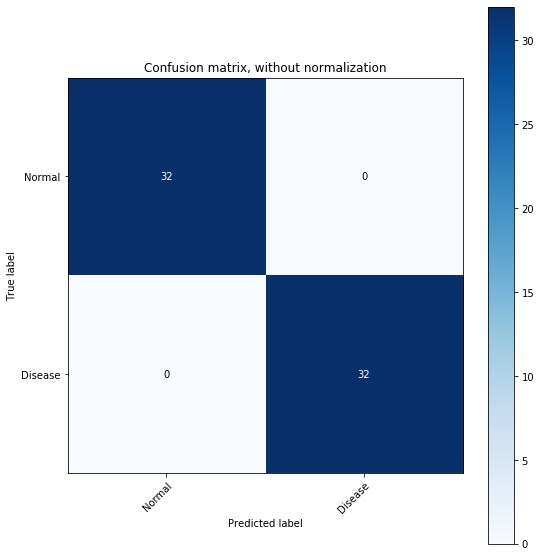

In [128]:
plot_confusion_matrix(y_train_sc.values[baseline_pipeline.testing_idxs], np.array(baseline_pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

In [129]:
X_train_red = X_train_sc[feature_idxs]
print(X_train_red.shape)
X_train_red.head()

(64, 6)


,sex,chol,restecg,oldpeak,slope,thal
215,0,341,0,3.0,1,3
246,0,409,0,1.9,1,3
266,0,327,2,3.4,1,2
180,1,353,1,1.2,1,3
301,1,131,1,1.2,1,3


In [130]:
X_valid_red = X_valid[feature_idxs]

nn = build_dnn(num_features=X_train_red.shape[1])
# nn.summary()

In [147]:
optimized_pipeline = ClusterPipeline(nn, [X_train_red, y_train_sc], [X_valid_red, y_valid], target_class=1)

optimized_pipeline.train_model(batch_size=10,epochs=10, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.630, Acc:0.8571
Prediction Accuracy
8/8 [==============================] - 0s 109us/step
Scores on data set: loss=0.668 accuracy=0.7500
Fold Correct: 6
Running worker: 1
Fold: 1 -> Loss:0.523, Acc:0.8393
Prediction Accuracy
8/8 [==============================] - 0s 90us/step
Scores on data set: loss=0.375 accuracy=0.8750
Fold Correct: 7
Running worker: 2
Fold: 2 -> Loss:0.592, Acc:0.8621
Prediction Accuracy
6/6 [==============================] - 0s 150us/step
Scores on data set: loss=0.636 accuracy=0.8333
Fold Correct: 5
Running worker: 3
Fold: 3 -> Loss:0.652, Acc:0.7759
Prediction Accuracy
6/6 [==============================] - 0s 124us/step
Scores on data set: loss=0.295 accuracy=1.0000
Fold Correct: 6
Running worker: 4
Fold: 4 -> Loss:0.543, Acc:0.8103
Prediction Accuracy
6/6 [==============================] - 0s 145us/step
Scores on data set: loss=0.440 accuracy=1.0000
Fold Correct: 6
Running worker: 5
Fold: 5 -> L

Confusion matrix, without normalization
[[30  2]
 [ 7 25]]


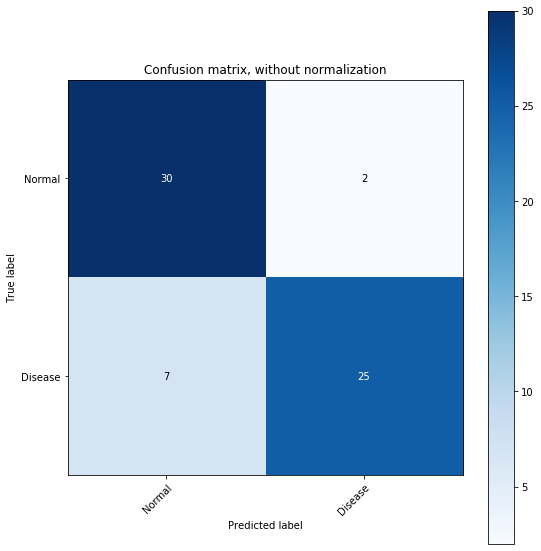

In [148]:
plot_confusion_matrix(y_train_sc.values[optimized_pipeline.testing_idxs], np.array(optimized_pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

Normalized confusion matrix
[[0.87179487 0.12820513]
 [0.18       0.82      ]]


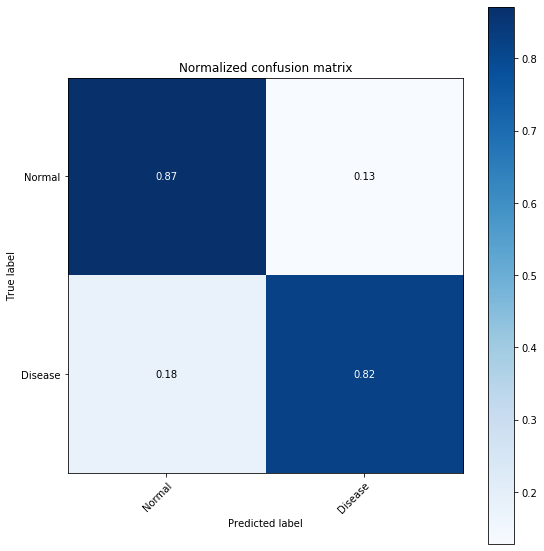

In [116]:
plot_confusion_matrix(y_train_red.values[new_pipeline.testing_idxs], np.array(new_pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]), normalize=True)